In [1]:
import fastai
from fastai.vision.all import *
from tqdm import tqdm
import pandas as pd
import numpy as np
import os
import random
import torch
from sklearn.model_selection import train_test_split
from datasets import load_dataset
from io import BytesIO

In [2]:
# Set the seed for reproducibility
SEED = 85
def seed_everything(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(SEED)

In [3]:
# Load the dataset from Hugging Face
hf_dataset = load_dataset("BahaaEldin0/NIH-Chest-Xray-14-Augmented-70-percent")

Resolving data files:   0%|          | 0/50 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/50 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/54873 [00:00<?, ? examples/s]

Generating valid split:   0%|          | 0/6859 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/6935 [00:00<?, ? examples/s]

Loading dataset shards:   0%|          | 0/49 [00:00<?, ?it/s]

In [4]:
# Convert the dataset to a Pandas DataFrame
train_df = hf_dataset['train'].to_pandas()
test_df = hf_dataset['test'].to_pandas()
valid_df = hf_dataset['valid'].to_pandas()

# Combine train and validation datasets for Fastai's DataBlock API
train_val_df = pd.concat([train_df, valid_df], ignore_index=True)

# Define disease labels based on the original dataset
disease_labels = [
    'Atelectasis', 'Consolidation', 'Infiltration', 'Pneumothorax', 
    'Edema', 'Emphysema', 'Fibrosis', 'Effusion', 'Pneumonia', 
    'Pleural_Thickening', 'Cardiomegaly', 'Nodule', 'Mass', 'Hernia'
]

# One-hot encode the disease labels
for disease in tqdm(disease_labels): 
    train_val_df[disease] = train_val_df['label'].apply(lambda x: 1 if disease in x else 0)
    test_df[disease] = test_df['label'].apply(lambda x: 1 if disease in x else 0)

# Split the unique patients
unique_patients = np.unique(train_val_df['Patient ID'])
train_val_df_patients, test_df_patients = train_test_split(
    unique_patients, test_size=0.2, random_state=SEED, shuffle=True
)
train_val_df = train_val_df[train_val_df['Patient ID'].isin(train_val_df_patients)]
test_df = test_df[test_df['Patient ID'].isin(test_df_patients)]

# Print sizes for verification
print('train_val size', train_val_df.shape[0])
print('test size', test_df.shape[0])

100%|██████████| 14/14 [00:03<00:00,  3.77it/s]

train_val size 49001
test size 1131


In [6]:
# Define item transforms and batch transforms
item_transforms = [
    Resize((224, 224)),
]

batch_transforms = [
    Flip(),
    Rotate(),
    Normalize.from_stats(*imagenet_stats),
]

# Define get_x and get_y functions
def get_x(row):
    return PILImage.create(BytesIO(row['image']['bytes']))

def get_y(row):
    labels = row[disease_labels].tolist()
    return labels

# Update the dataset to include the correct image paths
train_val_df['image_bytes'] = train_val_df['image'].apply(lambda x: x['bytes'])
test_df['image_bytes'] = test_df['image'].apply(lambda x: x['bytes'])


# Create DataBlock
dblock = DataBlock(
    blocks=(ImageBlock, MultiCategoryBlock(encoded=True, vocab=disease_labels)),
    splitter=RandomSplitter(valid_pct=0.125, seed=SEED),
    get_x=get_x,
    get_y=get_y,
    item_tfms=item_transforms,
    batch_tfms=batch_transforms
)

# Create DataLoaders
dls = dblock.dataloaders(train_val_df, bs=64,device=torch.device('cuda'))


In [7]:
!huggingface-cli download BahaaEldin0/ensembleModels volod2/models/volo_d2-70-10-20-split.pth --local-dir /workspace/models

volo_d2-70-10-20-split.pth: 100%|████████████| 695M/695M [00:08<00:00, 78.8MB/s]
Download complete. Moving file to /workspace/models/volod2/models/volo_d2-70-10-20-split.pth
/workspace/models/volod2/models/volo_d2-70-10-20-split.pth


In [8]:
# Define the model architecture
arch = 'volo_d2_224.sail_in1k'

# Define callbacks
cbs = [
    SaveModelCallback(monitor='valid_loss', min_delta=0.001, with_opt=True),
    EarlyStoppingCallback(monitor='valid_loss', min_delta=0.001, patience=5),
    ShowGraphCallback()
]

# Create learner
learn = vision_learner(dls, arch, metrics=[accuracy_multi, F1ScoreMulti(), RocAucMulti()], cbs=cbs)

# Load the pretrained weights
learn.load('/workspace/models/volod2/models/volo_d2-70-10-20-split')

# Use DataParallel for multi-GPU support if needed
learn.model = torch.nn.DataParallel(learn.model)

model.safetensors:   0%|          | 0.00/235M [00:00<?, ?B/s]

initial learning rate= 0.002511886414140463


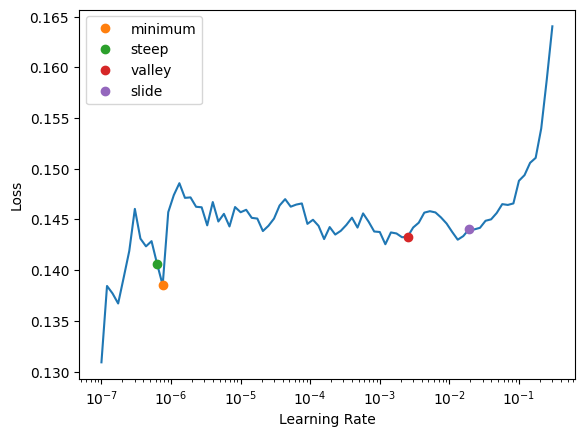

In [9]:
lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))
print('initial learning rate=', lrs.valley)

In [10]:
import torch
torch.cuda.get_device_name(0)

'NVIDIA GeForce RTX 4090'

epoch,train_loss,valid_loss,accuracy_multi,f1_score,roc_auc_score,time
0,0.139194,0.137625,0.951475,0.214162,0.861851,05:32
1,0.139109,0.137711,0.951428,0.191808,0.861712,05:31
2,0.141918,0.137783,0.951487,0.199038,0.861531,05:48


Better model found at epoch 0 with valid_loss value: 0.1376250684261322.


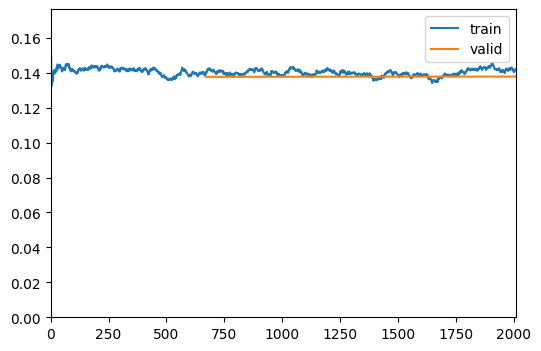

epoch,train_loss,valid_loss,accuracy_multi,f1_score,roc_auc_score,time
0,0.139555,0.137098,0.951650,0.203933,0.863662,05:55
1,0.138614,0.138097,0.951592,0.207629,0.859245,06:18
2,0.137873,0.139068,0.951230,0.234066,0.858823,06:23
3,0.132292,0.138597,0.951510,0.237140,0.858000,06:15
4,0.126148,0.139604,0.951557,0.244641,0.856923,06:09
5,0.124693,0.140173,0.950740,0.246176,0.857554,06:09


Better model found at epoch 0 with valid_loss value: 0.13709811866283417.


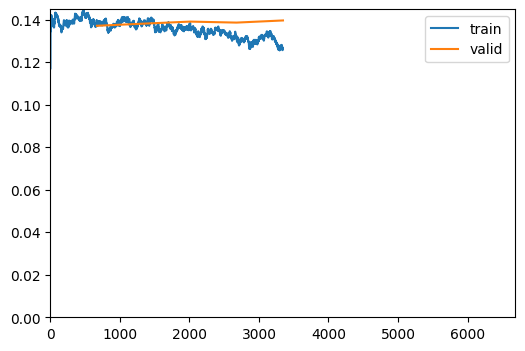

No improvement since epoch 0: early stopping


Path('models/volo2d_retrained.pth')

In [11]:
learn.fine_tune(freeze_epochs=3, epochs=10, base_lr=lrs.valley)

learn.save('volo2d_retrained')